## 1. Import libraries

# References:
1. https://www.kaggle.com/hely333/eda-regression

# Dataset
1. https://www.kaggle.com/marcinex1423/salesdb-grocery#salesDB_grocery_market.zip
1. https://www.kaggle.com/fayomi/advertising
2. https://www.kaggle.com/harlfoxem/housesalesprediction
3. https://github.com/awesomedata/awesome-public-datasets
4. https://www.kdnuggets.com/datasets/index.html
5. https://www.kaggle.com/devashish0507/big-mart-sales-prediction
6. https://archive.ics.uci.edu/ml/datasets/Statlog+(Vehicle+Silhouettes)

# 0. Imports
---

In [1]:
import warnings
import pandas                  as pd
import seaborn                 as sns
import statsmodels.api         as sm
import statsmodels.formula.api as smf

from matplotlib              import pyplot as plt
from IPython.core.display    import HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn                 import linear_model
from sklearn                 import metrics

warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [2]:
# --- Jupyter Notebook Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv( '../data/train.csv' )
df_stores_raw = pd.read_csv( '../data/store.csv' )

# Merge dataset
df_raw = pd.merge( df_sales_raw, df_stores_raw, on='Store', how='left' )

# 1.0. Data Preparation
---

In [5]:
df_raw.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


## 1.1. Rename Attributes

In [6]:
df1 = df_raw.copy()

In [7]:
# new columns name
new_cols=['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 
          'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo_interval']

# rename
df1.columns = new_cols

# 2.0. Describe data
---

In [8]:
df2 = df1.copy()

## 2.1. Data dimension

In [9]:
print( 'Number of Rows: {}'.format( df2.shape[0] ) )
print( 'Number of Columns: {}'.format( df2.shape[1] ) )

Number of Rows: 1017209
Number of Columns: 18


## 2.2. Data Type Attributes

In [15]:
df2['date'] = pd.to_datetime( df2['date'] )
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.3. Number of NA

In [16]:
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
store                           1017209 non-null int64
day_of_week                     1017209 non-null int64
date                            1017209 non-null datetime64[ns]
sales                           1017209 non-null int64
customers                       1017209 non-null int64
open                            1017209 non-null int64
promo                           1017209 non-null int64
state_holiday                   1017209 non-null object
school_holiday                  1017209 non-null int64
store_type                      1017209 non-null object
assortment                      1017209 non-null object
competition_distance            1014567 non-null float64
competition_open_since_month    693861 non-null float64
competition_open_since_year     693861 non-null float64
promo2                          1017209 non-null int64
promo2_since_week               509178 non-nul

## 2.4. Treat NA columns

### 2.4.0. promo2_since_week

In [18]:
df2['promo2_since_week'] = df2.apply( lambda x: x['date'].weekofyear if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

### 2.4.1. promo2_since_year

In [19]:
df2['promo2_since_year'] = df2.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

### 2.4.2. competition_distance

In [20]:
df2['competition_distance'] = df2['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

### 2.4.3. competition_open_since_month

In [21]:
df2['competition_open_since_month'] = df2.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 ) 

### 2.4.4. competition_open_since_year

In [22]:
df2['competition_open_since_year'] = df2.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

### 2.4.5. promo_interval

In [23]:
df2 = df2.drop( 'promo_interval', axis=1 )

## 2.4. Descriptive statistics

In [24]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
dtype: object

In [66]:
# separate the categorical from numerical features
num_attributes = df2.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df2.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
dat_attributes = df2.select_dtypes( include=['datetime64[ns]'] )

print( 'Num of Categorical: {}'.format( cat_attributes.shape[1] ) )
print( 'Num of Numerical: {}'.format( num_attributes.shape[1] ) )
print( 'Num of Date: {}'.format( dat_attributes.shape[1] ) )

Num of Categorical: 3
Num of Numerical: 13
Num of Date: 1


### 2.4.1. Central Tendency and Dispersion 

#### 2.4.1.1. Numerical Attributes

In [67]:
# Meausure of Central Tendency
ct1 = pd.DataFrame( num_attributes.apply( mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( median ) ).T


# Dispersion
d1 = pd.DataFrame( num_attributes.apply( std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T

m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'standard_deviation', 'kurtosis', 'skew']

m

,attributes,min,max,range,mean,median,standard_deviation,kurtosis,skew
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-1.200524,-0.000955
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,-1.246873,0.001593
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,1.778375,0.641460
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,7.091773,1.598650
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,1.090723,-1.758045
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,-1.762018,0.487838
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,0.815154,1.677842
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,147.789712,10.242344
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-1.232607,-0.042076
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,124.071304,-7.235657


### 2.4.1.2. Categorical Attributes

In [68]:
c = pd.DataFrame( cat_attributes.apply( lambda x: x.unique().shape[0], axis=0 ).reset_index() )
c.columns = ['Columns Names', 'Number of Levels']
print( c )

   Columns Names  Number of Levels
0  state_holiday                 5
1     store_type                 4
2     assortment                 3


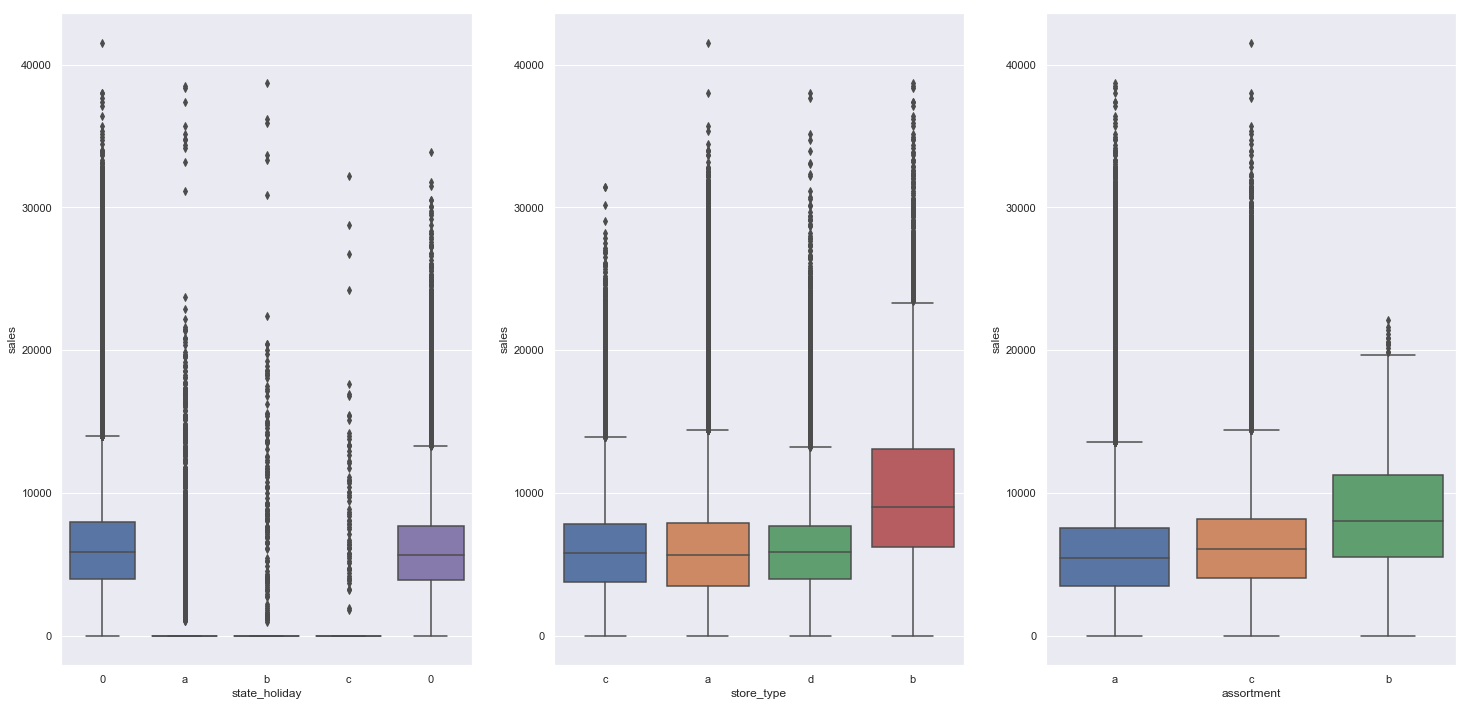

In [78]:
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=df2 );

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=df2 );

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=df2 );

# 3.0. EDA - Exploration Data Analysis
---

In [79]:
df3 = df2.copy()

## 3.1. Univariate Analysis

## 3.1.1. Response Variable

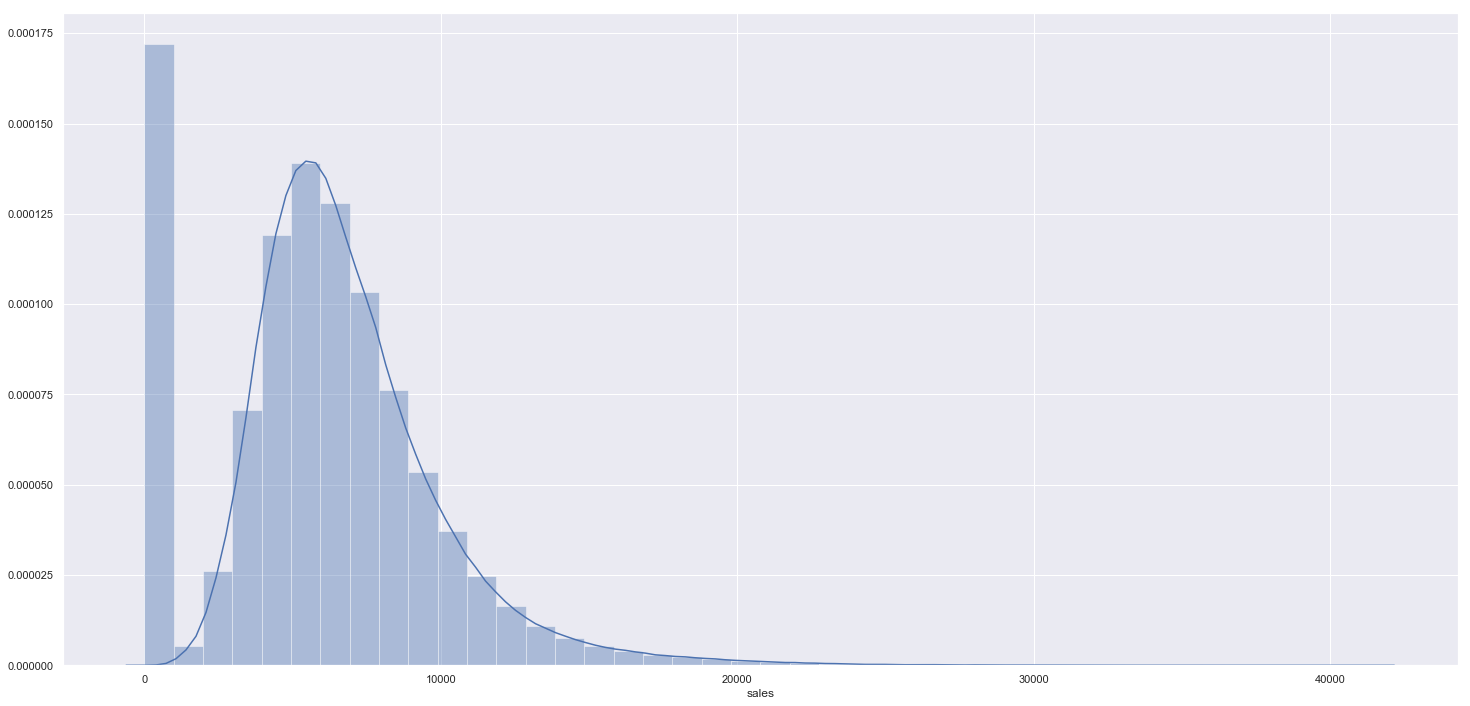

In [94]:
sns.distplot( df3['sales'], kde=True, bins=42 )

## 3.1.2. Numerical Predictors

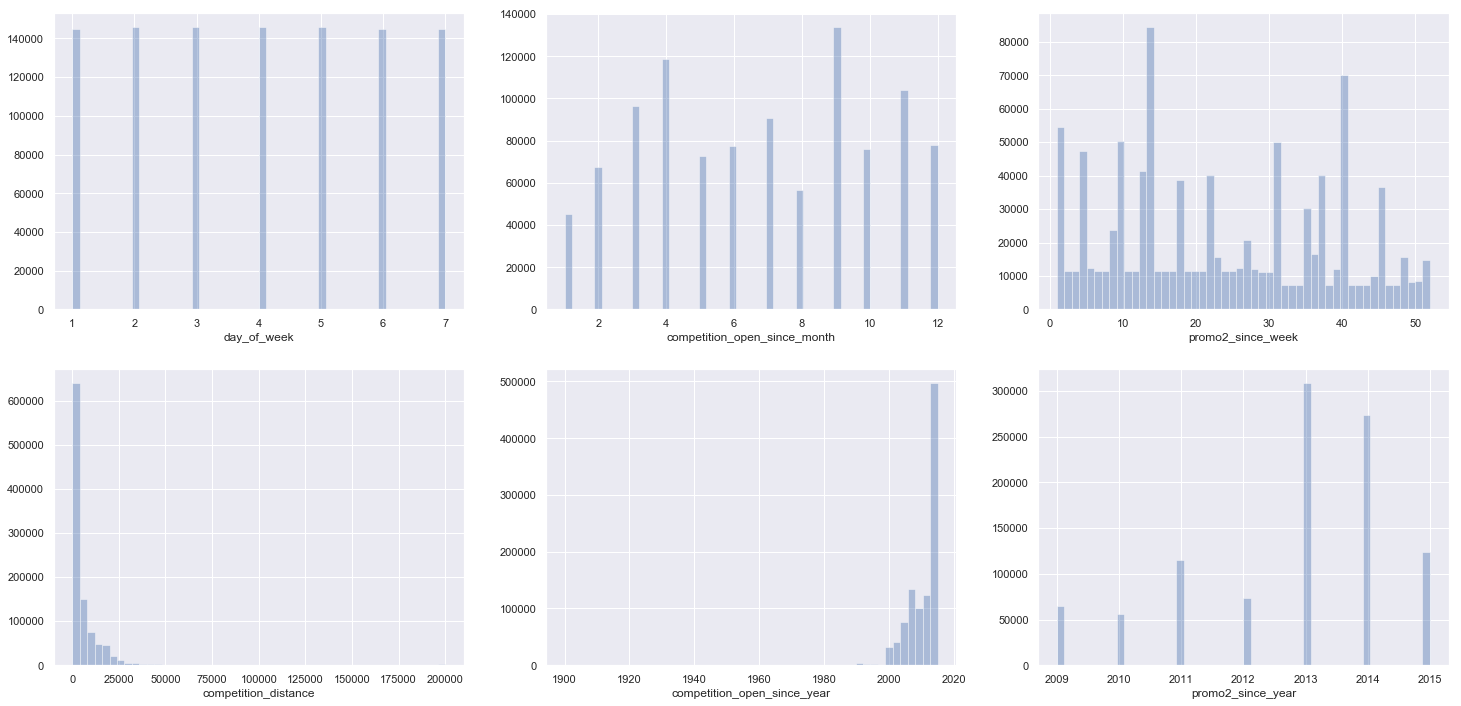

In [122]:
plt.subplot( 2, 3, 1 )
sns.distplot( df3['day_of_week'], kde=False );

plt.subplot( 2, 3, 4 )
sns.distplot( df3['competition_distance'], kde=False );

plt.subplot( 2, 3, 2 )
sns.distplot( df3['competition_open_since_month'], kde=False );

plt.subplot( 2, 3, 5 )
sns.distplot( df3['competition_open_since_year'], kde=False );

plt.subplot( 2, 3, 3 )
sns.distplot( df3['promo2_since_week'], kde=False );

plt.subplot( 2, 3, 6 )
sns.distplot( df3['promo2_since_year'], kde=False );

## 3.1.3. Categorical Predictors

In [123]:
cat_attributes.head()

,state_holiday,store_type,assortment
0,0,c,a
1,0,a,a
2,0,a,a
3,0,c,c
4,0,a,a
